Preprocess data for secRecon analysis
- we aligned preprocessing steps with Cheng et al. methods (doi: 10.1038/s41467-023-39367-8) https://github.com/Rene2718/SEC-seq_plasma-cell_nanovial/blob/main/scanpy_100-106-SecSEQ_nextseq.ipynb

Inputs:
-raw data per donor, available in GEO under accession number “GSE229042”.

Outputs:
- preprocessed anndata objects per donor (../data/preprocessed_data/exp10*.h5)
-- concatenated object (../data/preprocess_data/3data_raw.h5)
- UMAP plots with annotations/labels aligned with Cheng et al.
- anndata object with Leiden clusters, Ig subtype, high/low IgG metadata labels (../data/preprocessed_data/rna_analyzed.h5)
- anndata object with all labels and pseudotime in metadata (../data/preprocessed_data/rna_pseudotime.h5)

In [1]:
import scanpy as sc
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import numpy as np

from scipy.stats import pearsonr

In [2]:
# raw data import
exp100=sc.read_10x_h5('../data/raw_data/GSE229042_filtered_feature_bc_matrix_100.h5',gex_only=False)
exp105=sc.read_10x_h5('../data/raw_data/GSE229042_filtered_feature_bc_matrix_105.h5',gex_only=False)
exp106=sc.read_10x_h5('../data/raw_data/GSE229042_filtered_feature_bc_matrix_106.h5',gex_only=False)

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
exp100.var_names_make_unique()
exp105.var_names_make_unique()
exp106.var_names_make_unique()

In [ ]:
# apply filter thresholds (cells) per donor

In [4]:
# Exp100
sc.pp.filter_cells(exp100, min_genes=700) # Remove cells that have less than 700 genes expressed
# sc.pp.filter_genes(exp100, min_cells=3)
exp100.var['mt'] = exp100.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(exp100, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) # QC

In [5]:
# Exp105
sc.pp.filter_cells(exp105, min_genes=500)
# sc.pp.filter_genes(exp100, min_cells=3)
exp105.var['mt'] = exp105.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(exp105, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [6]:
# Exp106
sc.pp.filter_cells(exp106, min_genes=1000)
# sc.pp.filter_genes(exp100, min_cells=3)
exp106.var['mt'] = exp106.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(exp106, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [7]:
exp100 = exp100[exp100.obs.total_counts < 50000, :]
exp100 = exp100[exp100.obs.pct_counts_mt < 10, :]
exp105 = exp105[exp105.obs.total_counts < 35000, :]
exp105 = exp105[exp105.obs.pct_counts_mt < 2.5, :]
exp106 = exp106[exp106.obs.total_counts < 50000, :]
exp106 = exp106[exp106.obs.pct_counts_mt < 5, :]

In [8]:
# create copies of raw data with initial cells filtered out
exp100_=exp100.copy()
exp105_=exp105.copy()
exp106_=exp106.copy()

In [9]:
# filter cells with <2000 or <350 ADT barcodes
## (as noted by authors,#exp105 has other cell surface tag, IgG_ADT compromised, lower then exp100 and exp106)
exp100_ = exp100_[(exp100_.obs_vector('IgG_ADT') <2000), :]
exp106_ = exp106_[(exp106_.obs_vector('IgG_ADT') <2000), :]
exp105_ = exp105_[(exp105_.obs_vector('IgG_ADT') <350), :]

In [10]:
# store raw data in "counts" (unnormalized)
exp100_.layers["counts"] = exp100_.X.copy()

exp105_.layers["counts"] = exp105_.X.copy()

exp106_.layers["counts"] = exp106_.X.copy()

per donor/sample, visualize IG expression and IG scatter of RNA vs ADT counts
- then, doublets are filtered out based on set thresholds per IG
- object is saved after this filtering --> ../data/preprocessed_data/exp10*.h5

In [11]:
rna=exp106_
u=np.exp(1)

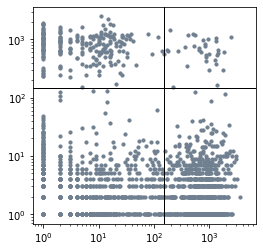

In [12]:
x='IGHM'
y='IGHA1' 
fig=plt.figure(figsize=(4,4)) 
plt.scatter(rna.obs_vector(x),rna.obs_vector(y),label="IG",color='slategrey',s=10) 
plt.xscale('log')
plt.yscale('log')
plt.axvline(x=u**5,linewidth=1, c='k') 
plt.axhline(y=u**5,linewidth=1, c='k')

In [13]:
#exp106
#cleanup doublet, we do this manually and observe the distribution simultaneously
#heavy chain isotype should be exclusive #IgM # IgA
m=u**5
a1=u**5
a2=u**3
g1=u**3.5
g2=u**3.5
g3=u**3.5
g4=u**2.5
rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHA1') > a1))] 
rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHA2') > a2))] 

rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHG1') > g1))] 
rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHG2') > g2))] 
rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHG3') > g3))] 
rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHG4') > g4))] 

rna=rna[~((rna.obs_vector('IGHA1') > a1) & (rna.obs_vector('IGHG1') > g1))] 
rna=rna[~((rna.obs_vector('IGHA1') > a1) & (rna.obs_vector('IGHG2') > g2))] 
rna=rna[~((rna.obs_vector('IGHA1') > a1) & (rna.obs_vector('IGHG3') > g3))] 
rna=rna[~((rna.obs_vector('IGHA1') > a1) & (rna.obs_vector('IGHG4') > g4))] 

rna=rna[~((rna.obs_vector('IGHA2') > a2) & (rna.obs_vector('IGHG1') > g1))] 

# #heavy chain isotype should be exclusive #IgG 
rna=rna[~((rna.obs_vector('IGHG1') > u**5) & (rna.obs_vector('IGHG2') > u**4))] 
rna=rna[~((rna.obs_vector('IGHG2') > u**5) & (rna.obs_vector('IGHG3') > u**3.6))] 

# #IGHG1 has linear plot likely conserve region

# # #light chain isotype should be exclusive
k=u**6.5
l1=u**6.5
l2=u**6.5
l3=u**6.5
rna=rna[~((rna.obs_vector('IGKC') >k) & (rna.obs_vector('IGLC1') > l1))] 
rna=rna[~((rna.obs_vector('IGKC') > k) & (rna.obs_vector('IGLC2') > l2))] 
rna=rna[~((rna.obs_vector('IGKC') > k) & (rna.obs_vector('IGLC3') > l3))] 

rna=rna[~((rna.obs_vector('IGLC1') > l1) & (rna.obs_vector('IGLC2') > l2))] 
rna=rna[~((rna.obs_vector('IGLC1') > l1) & (rna.obs_vector('IGLC3') > l3))] 

# #IGLC2 and IGLC3 has linear plot likely conserve region

# output preprocessed anndata obj
rna.write('../data/preprocessed_data/exp106.h5')

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


In [14]:
rna=exp105_
rna

AnnData object with n_obs × n_vars = 7090 × 36698
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

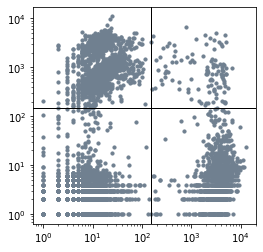

In [15]:
x='IGLC1'
y='IGLC3' 
fig=plt.figure(figsize=(4,4)) 
plt.scatter(rna.obs_vector(x),rna.obs_vector(y),label="IG",color='slategrey',s=10) 
plt.xscale('log')
plt.yscale('log')
plt.axvline(x=u**5,linewidth=1, c='k') 
plt.axhline(y=u**5,linewidth=1, c='k')

In [16]:
#exp105
#cleanup doublet, we do this manually and observe the distribution simultaneously
#heavy chain isotype should be exclusive #IgM # IgA

m=u**4.5
a1=u**4
a2=u**2
g1=u**3
g2=u**3
g3=u**5
g4=u**3.5
rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHA1') > a1))] 
rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHG1') > g1))] 
rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHG2') > g2))] 
rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHG3') > g3))] 
rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHG4') > g4))] 

rna=rna[~((rna.obs_vector('IGHA1') > a1) & (rna.obs_vector('IGHG1') > g1))] 
rna=rna[~((rna.obs_vector('IGHA1') > a1) & (rna.obs_vector('IGHG2') > g2))] 
rna=rna[~((rna.obs_vector('IGHA1') > a1) & (rna.obs_vector('IGHG3') > g3))] 
rna=rna[~((rna.obs_vector('IGHA1') > a1) & (rna.obs_vector('IGHG4') > g4))] 


# #heavy chain isotype should be exclusive #IgG 
rna=rna[~((rna.obs_vector('IGHG1') > u**5.3) & (rna.obs_vector('IGHG2') > u**3.5))] 
rna=rna[~((rna.obs_vector('IGHG1') > u**3) & (rna.obs_vector('IGHG3') > u**5.5))] 
rna=rna[~((rna.obs_vector('IGHG1') > u**3) & (rna.obs_vector('IGHG4') > u**3.5))] 
rna=rna[~((rna.obs_vector('IGHG2') > u**3.5) & (rna.obs_vector('IGHG3') > u**3.5))] 
rna=rna[~((rna.obs_vector('IGHG2') > u**3.5) & (rna.obs_vector('IGHG4') > u**3.5))] 
rna=rna[~((rna.obs_vector('IGHG3') > u**3.5) & (rna.obs_vector('IGHG4') > u**3.5))] 

# # #IGHG1 has linear plot likely conserve region

# # #light chain isotype should be exclusive
k=u**6
l1=u**6
l2=u**6
l3=u**5
rna=rna[~((rna.obs_vector('IGKC') >k) & (rna.obs_vector('IGLC1') > l1))] 
rna=rna[~((rna.obs_vector('IGKC') > k) & (rna.obs_vector('IGLC2') > l2))] 
rna=rna[~((rna.obs_vector('IGKC') > k) & (rna.obs_vector('IGLC3') > l3))] 

rna=rna[~((rna.obs_vector('IGLC1') > l1) & (rna.obs_vector('IGLC2') > l2))] 
rna=rna[~((rna.obs_vector('IGLC1') > l1) & (rna.obs_vector('IGLC3') > l3))] 

#IGLC2 and IGLC3 has linear plot likely conserve region

# output preprocessed anndata obj
rna.write('../data/preprocessed_data/exp105.h5')

In [17]:
rna=exp100_
rna

AnnData object with n_obs × n_vars = 4109 × 36692
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

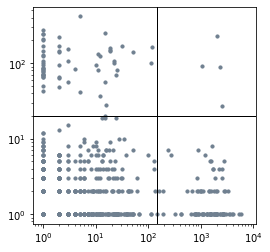

In [18]:
x='IGHM'
y='IGHA2' 
fig=plt.figure(figsize=(4,4)) 
plt.scatter(rna.obs_vector(x),rna.obs_vector(y),label="IG",color='slategrey',s=10) 
plt.xscale('log')
plt.yscale('log')
plt.axvline(x=u**5,linewidth=1, c='k') 
plt.axhline(y=u**3,linewidth=1, c='k')

In [19]:
#exp100
#cleanup doublet, we do this manually and observe the distribution simultaneously
#heavy chain isotype should be exclusive #IgM # IgA

m=u**5
a1=u**5
a2=u**3
g1=u**4.5
g2=u**4.5
g3=u**6
g4=u**5

rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHA1') > a1))] 
rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHA2') > a2))] 

rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHG1') > g1))] 
rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHG2') > g2))] 
rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHG3') > g3))] 
rna=rna[~((rna.obs_vector('IGHM') > m) & (rna.obs_vector('IGHG4') > g4))] 

rna=rna[~((rna.obs_vector('IGHA1') > a1) & (rna.obs_vector('IGHG1') > g1))] 
rna=rna[~((rna.obs_vector('IGHA1') > a1) & (rna.obs_vector('IGHG2') > g2))] 
rna=rna[~((rna.obs_vector('IGHA1') > a1) & (rna.obs_vector('IGHG3') > g3))] 
rna=rna[~((rna.obs_vector('IGHA1') > a1) & (rna.obs_vector('IGHG4') > g4))] 


# # #heavy chain isotype should be exclusive #IgG 
rna=rna[~((rna.obs_vector('IGHG1') > u**5) & (rna.obs_vector('IGHG2') > u**4.5))] 
rna=rna[~((rna.obs_vector('IGHG1') > u**5) & (rna.obs_vector('IGHG3') > u**6))] 
rna=rna[~((rna.obs_vector('IGHG1') > u**5) & (rna.obs_vector('IGHG4') > u**4.5))] 
rna=rna[~((rna.obs_vector('IGHG2') > u**4.5) & (rna.obs_vector('IGHG3') > u**4.5))] 
rna=rna[~((rna.obs_vector('IGHG2') > u**4.5) & (rna.obs_vector('IGHG4') > u**5))] 
rna=rna[~((rna.obs_vector('IGHG3') > u**4.5) & (rna.obs_vector('IGHG4') > u**5))] 

# # # #IGHG1 has linear plot likely conserve region

# # # #light chain isotype should be exclusive
k=u**7
l1=u**6
l2=u**6
l3=u**6
rna=rna[~((rna.obs_vector('IGKC') >k) & (rna.obs_vector('IGLC1') > l1))] 
rna=rna[~((rna.obs_vector('IGKC') > k) & (rna.obs_vector('IGLC2') > l2))] 
rna=rna[~((rna.obs_vector('IGKC') > k) & (rna.obs_vector('IGLC3') > l3))] 

rna=rna[~((rna.obs_vector('IGLC1') > l1) & (rna.obs_vector('IGLC2') > l2))] 
rna=rna[~((rna.obs_vector('IGLC1') > l1) & (rna.obs_vector('IGLC3') > l3))] 

# #IGLC2 and IGLC3 has linear plot likely conserve region

# output preprocessed anndata obj
rna.write('../data/preprocessed_data/exp100.h5')

# Dimension Reduction, Clustering
- aligned with previous analysis https://github.com/Rene2718/SEC-seq_plasma-cell_nanovial/blob/main/scanpy_100-106-SecSEQ_nextseq.ipynb

In [20]:
import scanpy as sc
import anndata
import bbknn
import pandas as pd
import numpy as np

import seaborn as sns

from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import scipy

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/pyth

In [21]:
# read in saved data
exp100=sc.read('../data/preprocessed_data/exp100.h5',gex_only=False)
exp105=sc.read('../data/preprocessed_data/exp105.h5',gex_only=False)
exp106=sc.read('../data/preprocessed_data/exp106.h5',gex_only=False)

In [58]:
# Concatenate raw counts from three donors/sample into object called data
data = exp100.concatenate(exp105, exp106, batch_key='sample')

# write object for concatenated 3 donor file
data.write('../data/preprocessed_data/3data_raw.h5')

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [82]:
# isolate just gene expression layer of obj (exclude 1 IgG_ADT feature)
rna=data[:, data.var["feature_types"] == "Gene Expression"].copy() # extract gene expression layer
rna.raw = rna.copy()

# rna.raw.obs_vector('IgG_ADT') = data.obs_vector('IgG_ADT')

rna

AnnData object with n_obs × n_vars = 12892 × 36691
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2'
    layers: 'counts'

In [83]:
# normalize and log counts per cell --> stored in rna.X (raw still in rna.raw.X)
## https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.normalize_total.html
## each observation (cell) has a total count equal
##   to the median of total counts for observations (cells) before normalization
## updates adata with normalized version of the original adata.X and adata.layers
### https://discourse.scverse.org/t/differences-between-x-raw-x-and-raw-in-anndata-object/1192/2
sc.pp.normalize_total(rna) # normalize and log counts per cell --> stored in rna.X (raw still in rna.raw.X)
sc.pp.log1p(rna)
rna 

AnnData object with n_obs × n_vars = 12892 × 36691
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2'
    uns: 'log1p'
    layers: 'counts'

perform dimension reduction with bbknn batch correction per donor and clustering to identify leiden/UMAP clusters

In [84]:
sc.pp.pca(rna) # perform pca
sc.external.pp.bbknn(rna, batch_key='sample') # batch balanced kNN;batch correction and find neighbors needed for umap/clustering

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


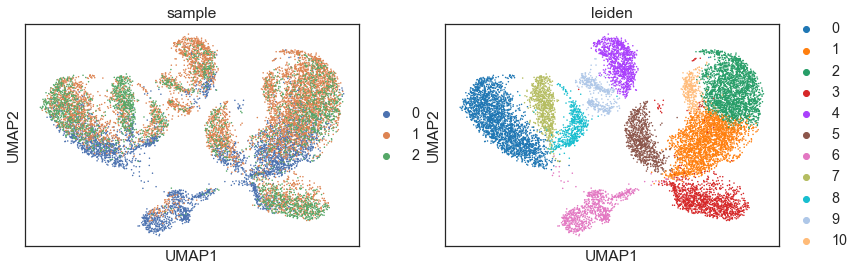

In [85]:
# visualize umap/data after bbknn batch correction/balance
sc.tl.umap(rna)
sc.tl.leiden(rna,resolution = 0.7)
sc.pl.umap(rna, color=['sample','leiden'])

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


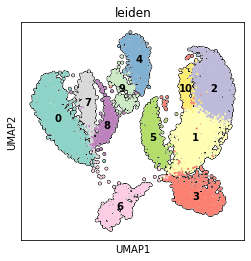

In [31]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(rna, color=["leiden"], size=20,alpha=1,legend_loc="on data", 
               add_outline=True,palette='Set3', show=False)
plt.savefig('../results/preprocess/leiden.pdf')

# note: compared with Cheng et al. UMAP on how clusters are defined/subsetted in downstream analysis
## cluster initialization and calling can produce different ordering based on seed or package versioning, 
## We have confirmed that the cluster names/IDs are equivalent in metadata

classify high/low IgG secretion

In [86]:
#define ig category by ig count
M=rna[(rna.obs_vector('IGHM')> 4) & (rna.obs_vector('IGHA1') < 4.5)& (rna.obs_vector('IGHG1') < 4.5)]
A=rna[(rna.obs_vector('IGHA1') > 4.5)&(rna.obs_vector('IGHM')<4.6)&(rna.obs_vector('IGHG1')<3) ]
G1=rna[(rna.obs_vector('IGHG1') > 3)&(rna.obs_vector('IGHG2')<4)]
G3=rna[(rna.obs_vector('IGHG1') < 3)&(rna.obs_vector('IGHG3')>3.5)]
G2=rna[(rna.obs_vector('IGHG2') > 3.2)&(rna.obs_vector('IGHG3') <4.3)]
G4=rna[(rna.obs_vector('IGHG4') > 4)&(rna.obs_vector('IGHG3') <3.5)]
K=rna[(rna.obs_vector('IGKC')> 6.5) & (rna.obs_vector('IGLC1') < 6)& (rna.obs_vector('IGLC2') < 6)& (rna.obs_vector('IGLC3') < 6)]
L=rna[(rna.obs_vector('IGKC')< 6.5) & ((rna.obs_vector('IGLC1') > 6)|(rna.obs_vector('IGLC2') > 6)|(rna.obs_vector('IGLC3') > 6)|(rna.obs_vector('IGLC5') > 0.25)|(rna.obs_vector('IGLC6') > 0.25)|(rna.obs_vector('IGLC7') > 6))]

In [87]:
# init these new cols in metadata
rna.obs['Ig']='x'
rna.obs['IgL']='x'
rna.obs['IgH']='x'

In [88]:
# extract cell indexes for each subpopulation
m_i=M.obs.index
a_i=A.obs.index
kap_i=K.obs.index
lam_i=L.obs.index
g1_i=G1.obs.index
g2_i=G2.obs.index
g3_i=G3.obs.index
g4_i=G4.obs.index

# assign subpopulation group back to rna aggregate metadata columns
rna.obs.loc[m_i,'Ig'] ='M'
rna.obs.loc[a_i,'Ig'] ='A'
rna.obs.loc[g1_i,'Ig'] ='G'
rna.obs.loc[g2_i,'Ig'] = 'G'
rna.obs.loc[g3_i,'Ig'] = 'G'
rna.obs.loc[g4_i,'Ig'] = 'G'


rna.obs.loc[kap_i, 'IgL'] = 'kappa'
rna.obs.loc[lam_i, 'IgL'] = 'lambda'

rna.obs.loc[m_i, 'IgH'] = 'M'
rna.obs.loc[a_i, 'IgH'] = 'A'
rna.obs.loc[g1_i, 'IgH'] = 'G1'
rna.obs.loc[g2_i, 'IgH'] = 'G2'
rna.obs.loc[g3_i, 'IgH'] = 'G3'
rna.obs.loc[g4_i, 'IgH'] = 'G4'

In [89]:
rna.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample,leiden,Ig,IgL,IgH
AAACCCAAGTACTGTC-1-0,3128,3128,21325.0,909.0,4.262603,0,1,G,kappa,G1
AAACCCAAGTGAATAC-1-0,1774,1774,6060.0,518.0,8.547854,0,3,M,kappa,M
AAACCCAGTCCACAGC-1-0,2914,2914,19771.0,792.0,4.005867,0,1,G,kappa,G1
AAACCCATCACAGTGT-1-0,3122,3122,12608.0,757.0,6.004125,0,1,M,kappa,M
AAACCCATCCCTCTCC-1-0,3021,3021,16684.0,247.0,1.480460,0,1,G,kappa,G1
...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGACTCCT-1-2,2467,2467,14874.0,309.0,2.077451,2,7,M,lambda,M
TTTGTTGAGGTACAAT-1-2,2159,2159,14240.0,170.0,1.193820,2,7,M,lambda,M
TTTGTTGAGTAACGAT-1-2,2665,2665,18230.0,674.0,3.697202,2,5,A,kappa,A
TTTGTTGCACGTTGGC-1-2,2211,2211,19481.0,384.0,1.971151,2,5,A,kappa,A


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


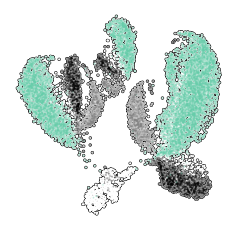

In [37]:
# visualize the A,M,G subpopulations on umap

## A: grey
## M: black
## G: medium aquamarine --> our population of interest for downstream analysis
## x (unassigned): white

with rc_context({'figure.figsize': (4, 4)}):
#     ax = sc.pl.umap(rna, size=10, add_outline=True, outline_width=(0.5, 0.05),frameon=True, show=False)
    
    ax=sc.pl.umap(rna, color=["Ig"], size=15,
               palette={'A':'grey','M':'k','G':'mediumaquamarine','x':'white'},alpha=0.4,add_outline=True,
              frameon=False,legend_loc='None', show=False)
    ax.set_title('')
    plt.savefig('../results/preprocess/umap_heavychain.pdf')

In [90]:
# # make copy of concatenated sample 100, 105, 106 obj raw data/counts 
datar=data[data.obs.index.isin(rna.obs.index)]

# https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.log1p.html#scanpy.pp.log1p
## updates datar with computed ln(counts+1) of data matrix
sc.pp.log1p(datar)
rna.raw = datar # add log1p counts to rna.raw ## includes IgG_ADT log(counts)

## raw counts data is still in rna.layers['counts']; without IgG_ADT

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/var/folders/bm/jsmvb47d0nn6z2lrn12ymbvm0000gn/T/ipykernel_39459/1235719463.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(s0M.raw.obs_vector('IgG_ADT'), kde=True,
/var/folders/bm/jsmvb47d0nn6z2lrn12ymbvm0000gn/T/ipykernel_39459/1235719463.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 

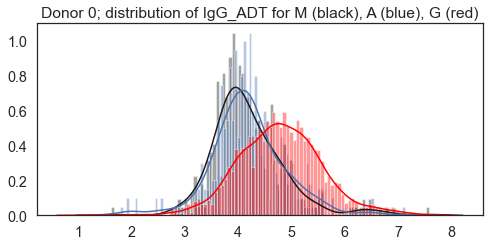

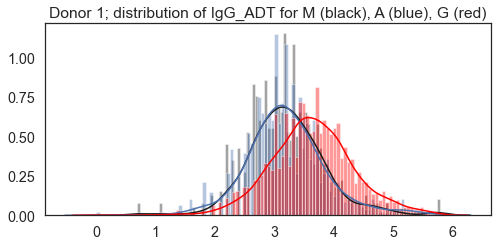

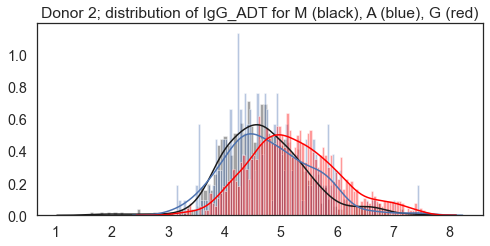

In [93]:
# VISUALIZE DISTRIBUTION OF IgG_ADT for M,A,G subpopulations
## rna.raw contains log1p counts 

fig = plt.figure(figsize=(8,12))

ax = sns.set(font_scale=1.3) 
ax = sns.set_style("white")
# sns.kdeplot( M.obs_vector('IgG_ADT'), #kde=False,
#    color = 'slategrey',shade=True)
ax1 = fig.add_subplot(311)
s0=rna[rna.obs['sample']=='0'] # subset gene expr for donor 0
s0M=s0[s0.obs.Ig=='M']
s0A=s0[s0.obs.Ig=='A']
s0G=s0[s0.obs.Ig=='G']
ax1 = sns.distplot(s0M.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'k',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s0A.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'b',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s0G.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'red',bins=100,norm_hist=True
        )#,bins=int(30))
# sns.kdeplot( A.obs_vector('IgG_ADT'), #kde=False,
#              color = 'purple',shade=True)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
ax1.set_title('Donor 0; distribution of IgG_ADT for M (black), A (blue), G (red)')
# plt.xticks([])
# plt.yticks([])

# # plt.axvline(x=5,linewidth=1,c='purple' )
fig = plt.figure(figsize=(8,12))

ax = sns.set(font_scale=1.3) 
ax = sns.set_style("white")
# sns.kdeplot( M.obs_vector('IgG_ADT'), #kde=False,
#    color = 'slategrey',shade=True)
ax1 = fig.add_subplot(311)
s1=rna[rna.obs['sample']=='1']
s1M=s1[s1.obs.Ig=='M']
s1A=s1[s1.obs.Ig=='A']
s1G=s1[s1.obs.Ig=='G']
ax1 = sns.distplot(s1M.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'k',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s1A.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'b',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s1G.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'red',bins=100,norm_hist=True
        )#,bins=int(30))
# sns.kdeplot( A.obs_vector('IgG_ADT'), #kde=False,
#              color = 'purple',shade=True)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
ax1.set_title('Donor 1; distribution of IgG_ADT for M (black), A (blue), G (red)')

# plt.xticks([])
# plt.yticks([])

# # plt.axvline(x=5,linewidth=1,c='purple' )


fig = plt.figure(figsize=(8,12))

ax = sns.set(font_scale=1.3) 
ax = sns.set_style("white")
# sns.kdeplot( M.obs_vector('IgG_ADT'), #kde=False,
#    color = 'slategrey',shade=True)
ax1 = fig.add_subplot(311)
s2=rna[rna.obs['sample']=='2']
s2M=s2[s2.obs.Ig=='M']
s2A=s2[s2.obs.Ig=='A']
s2G=s2[s2.obs.Ig=='G']
ax1 = sns.distplot(s2M.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'k',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s2A.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'b',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s2G.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'red',bins=100,norm_hist=True
        )#,bins=int(30))
# sns.kdeplot( A.obs_vector('IgG_ADT'), #kde=False,
#              color = 'purple',shade=True)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
ax1.set_title('Donor 2; distribution of IgG_ADT for M (black), A (blue), G (red)')

# plt.xticks([])
# plt.yticks([])

# # plt.axvline(x=5,linewidth=1,c='purple' )

plt.show()

/var/folders/bm/jsmvb47d0nn6z2lrn12ymbvm0000gn/T/ipykernel_39459/3985844099.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(s0M.raw.obs_vector('IgG_ADT'), kde=True,
/var/folders/bm/jsmvb47d0nn6z2lrn12ymbvm0000gn/T/ipykernel_39459/3985844099.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 

(0.0, 0.8)

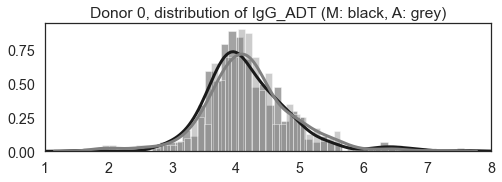

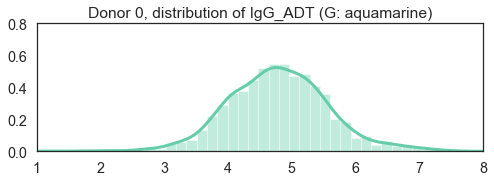

In [94]:
fig = plt.figure(figsize=(8,8))

ax = sns.set(font_scale=1.3) 
ax = sns.set_style("white")
# sns.kdeplot( M.obs_vector('IgG_ADT'), #kde=False,
#    color = 'slategrey',shade=True)
ax1 = fig.add_subplot(311)
s0=rna[rna.obs['sample']=='0']
s0M=s0[s0.obs.Ig=='M']
s0A=s0[s0.obs.Ig=='A']
s0G=s0[s0.obs.Ig=='G']

ax1 = sns.distplot(s0M.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'k',bins=50,norm_hist=True, kde_kws=dict(linewidth=3))
        
ax1 = sns.distplot(s0A.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'grey',bins=50,norm_hist=True,kde_kws=dict(linewidth=3))
ax1.set_title('Donor 0, distribution of IgG_ADT (M: black, A: grey)')
        #,bins=int(30))
# sns.kdeplot( A.obs_vector('IgG_ADT'), #kde=False,
#              color = 'purple',shade=True)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
plt.xlim(1,8)

# plt.xticks([])
# plt.yticks([])
fig = plt.figure(figsize=(8,8))

ax = sns.set(font_scale=1.3) 
ax = sns.set_style("white")
# sns.kdeplot( M.obs_vector('IgG_ADT'), #kde=False,
#    color = 'slategrey',shade=True)
ax1 = fig.add_subplot(311)

ax1 = sns.distplot(s0G.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'mediumaquamarine',bins=40,norm_hist=True,kde_kws=dict(linewidth=3))
        #,bins=int(30))
# sns.kdeplot( A.obs_vector('IgG_ADT'), #kde=False,
#              color = 'purple',shade=True)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
ax1.set_title('Donor 0, distribution of IgG_ADT (G: aquamarine)')

plt.xlim(1,8)
plt.ylim(0,0.8)
# plt.xticks([])
# plt.yticks([])

In [95]:
# append M and A population per donor
AM0=np.append(s0M.raw.obs_vector('IgG_ADT'),s0A.raw.obs_vector('IgG_ADT'))
AM1=np.append(s1M.raw.obs_vector('IgG_ADT'),s1A.raw.obs_vector('IgG_ADT'))
AM2=np.append(s2M.raw.obs_vector('IgG_ADT'),s2A.raw.obs_vector('IgG_ADT'))

In [96]:
# obtain min IgG threshold using 90% of A, M IgG_ADT pdf per donor
vmin0=np.quantile(AM0,0.9)
vmin1=np.quantile(AM1,0.9)
vmin2=np.quantile(AM2,0.9)
(vmin0,vmin1,vmin2)

(5.010612964630127, 3.97029185295105, 5.686284732818604)

In [97]:
# IgG population per donor
G0=s0G.raw.obs_vector('IgG_ADT')
G1=s1G.raw.obs_vector('IgG_ADT')
G2=s2G.raw.obs_vector('IgG_ADT')

In [98]:
# obtain max (100%) threshold of 
vmax0=np.quantile(G0, 1)
vmax1=np.quantile(G1, 1)
vmax2=np.quantile(G2, 1)
(vmax0,vmax1,vmax2)

(7.533694, 5.855072, 7.555382)

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/anndata/_core/annd

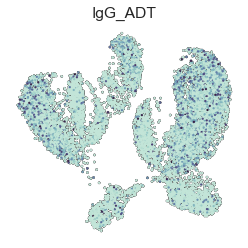

In [99]:
# visualize IgG_ADT concentration over all cells combining 3 donors
c=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
s=20

with rc_context({'figure.figsize': (4.2, 4)}):

    ax = sc.pl.umap(rna, size=10, add_outline=True,frameon=False, show=False,outline_width=(0.3, 0.05),)# outline_width=(0.2, 0.05), outline_color=('grey', 'white'),frameon=True, show=False)
    
    sc.pl.umap(s0,color=['IgG_ADT'], legend_loc='none',size=s,
                    cmap=c,vmin=vmin0,vmax=vmax0,colorbar_loc=None, ax=ax,show=False,
              )
    sc.pl.umap(s1,color=['IgG_ADT'], legend_loc='none',size=s,
                 cmap=c,
                    ax=ax,vmin=vmin1, vmax=vmax1,colorbar_loc=None,show=False,
              )
              
    sc.pl.umap(s2,color=['IgG_ADT'], legend_loc='none',size=s,cmap=c,
                    ax=ax,vmin=vmin2, vmax=vmax2,colorbar_loc=None,show=False,
              )

In [100]:
data0 = G0
data1 = G1
data2 = G2

# Fit a normal distribution to the IgG_ADT data per donor:
## obtain mean {mu} and standard deviation {std} stats per donor's G population
mu0, std0 = scipy.stats.norm.fit(data0)
mu1, std1 = scipy.stats.norm.fit(data1)
mu2, std2 = scipy.stats.norm.fit(data2)

Fit results: mu = 4.79,  std = 0.78
Fit results: mu = 3.63,  std = 0.70
Fit results: mu = 5.23,  std = 0.80


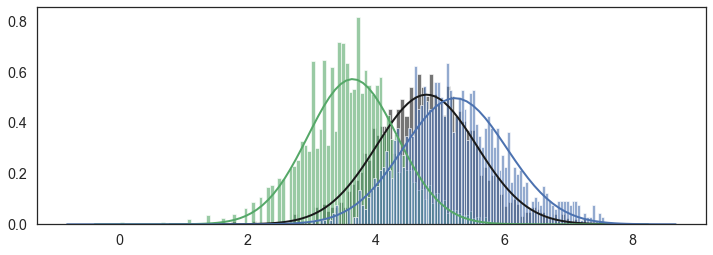

In [101]:
# plot fitted IgG_ADT distributions per donor, G population only
## DONOR 0: black; DONOR 1: green; DONOR 2: blue

fig = plt.figure(figsize=(12,4))
# Plot the histogram.
plt.hist(data0, bins=100, density=True, alpha=0.6, color='k')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu0, std0)
plt.plot(x, p, 'k', linewidth=2)
print( "Fit results: mu = %.2f,  std = %.2f" % (mu0, std0))


plt.hist(data1, bins=100, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu1, std1)
plt.plot(x, p, 'g', linewidth=2)
print( "Fit results: mu = %.2f,  std = %.2f" % (mu1, std1))

plt.hist(data2, bins=100, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu2, std2)
plt.plot(x, p, 'b', linewidth=2)
print( "Fit results: mu = %.2f,  std = %.2f" % (mu2, std2))

In [102]:
# find min 90% cutoff for M or A populations per donor --> assess as lower cutoff for IgG (G) populations
c0=min((np.quantile(s0M.raw.obs_vector('IgG_ADT'), 0.90), np.quantile(s0A.raw.obs_vector('IgG_ADT'), 0.90)))
c1=min((np.quantile(s1M.raw.obs_vector('IgG_ADT'), 0.90),np.quantile(s1A.raw.obs_vector('IgG_ADT'), 0.90)))
c2=min((np.quantile(s2M.raw.obs_vector('IgG_ADT'), 0.90),np.quantile(s2A.raw.obs_vector('IgG_ADT'), 0.90)))
(c0,c1,c2)

(4.957917881011963, 3.9512436389923096, 5.641551971435547)

In [103]:
#hi secretors lower IgG cutoff per donor ## refer to a few cells back: 90% percentile of IgG_ADT counts for AM populations per donor (np.quantile(AM*,0.9))
(c0,c1,c2)=(vmin0,vmin1,vmin2)
(c0,c1,c2)

(5.010612964630127, 3.97029185295105, 5.686284732818604)

In [106]:
#upper cutoff for "low IgG secretors" per donor
c0_=mu0+(mu0-c0)/std0
c1_=mu1+(mu1-c1)/std1
c2_=mu2+(mu2-c2)/std2
(c0_,c1_,c2_)

(4.509797972567184, 3.152641751879678, 4.670469022490362)

In [107]:
# create populations for high (h) and low (n) IgG populations -- includes M,A,G cells
s0h=s0[s0.raw.obs_vector('IgG_ADT')>=c0] # hi
s0n=s0[s0.raw.obs_vector('IgG_ADT')<c0_] # low
s1h=s1[s1.raw.obs_vector('IgG_ADT')>=c1]
s1n=s1[s1.raw.obs_vector('IgG_ADT')<c1_]
s2h=s2[s2.raw.obs_vector('IgG_ADT')>=c2]
s2n=s2[s2.raw.obs_vector('IgG_ADT')<c2_]

In [108]:
# init a column in metadata for original rna object to assign "sec" phenotype
rna.obs['sec']='x'
rna.obs.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample,leiden,Ig,IgL,IgH,sec
AAACCCAAGTACTGTC-1-0,3128,3128,21325.0,909.0,4.262603,0,1,G,kappa,G1,x
AAACCCAAGTGAATAC-1-0,1774,1774,6060.0,518.0,8.547854,0,3,M,kappa,M,x
AAACCCAGTCCACAGC-1-0,2914,2914,19771.0,792.0,4.005867,0,1,G,kappa,G1,x
AAACCCATCACAGTGT-1-0,3122,3122,12608.0,757.0,6.004125,0,1,M,kappa,M,x
AAACCCATCCCTCTCC-1-0,3021,3021,16684.0,247.0,1.480460,0,1,G,kappa,G1,x


In [109]:
# obtain cell indexes and assign phenotype to metadata col
s0h_i=s0h.obs.index
s0n_i=s0n.obs.index
s1h_i=s1h.obs.index
s1n_i=s1n.obs.index
s2h_i=s2h.obs.index
s2n_i=s2n.obs.index


rna.obs.loc[s0h_i,'sec'] ='hi'
rna.obs.loc[s1h_i,'sec'] ='hi'
rna.obs.loc[s2h_i,'sec'] ='hi'
rna.obs.loc[s0n_i,'sec'] ='lo'
rna.obs.loc[s1n_i,'sec'] ='lo'
rna.obs.loc[s2n_i,'sec'] ='lo'

rna.obs.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample,leiden,Ig,IgL,IgH,sec
AAACCCAAGTACTGTC-1-0,3128,3128,21325.0,909.0,4.262603,0,1,G,kappa,G1,x
AAACCCAAGTGAATAC-1-0,1774,1774,6060.0,518.0,8.547854,0,3,M,kappa,M,x
AAACCCAGTCCACAGC-1-0,2914,2914,19771.0,792.0,4.005867,0,1,G,kappa,G1,hi
AAACCCATCACAGTGT-1-0,3122,3122,12608.0,757.0,6.004125,0,1,M,kappa,M,hi
AAACCCATCCCTCTCC-1-0,3021,3021,16684.0,247.0,1.480460,0,1,G,kappa,G1,hi


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


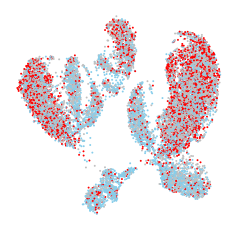

In [110]:
# viz high and low igg secretors for all cells in umap

with rc_context({'figure.figsize': (4, 4)}):

    ax=sc.pl.umap(rna,color='sec', legend_loc='none',size=15,show=False, alpha=1,
               palette= {'hi':'red',
                        'x':'silver',
                        'lo':'skyblue',
                        },
                add_outline=False, outline_width=(0.2, 0.05), outline_color=('silver', 'white'),
               frameon=False
               
     )
    ax.set_title('')

In [111]:
# write h5 files with metadata allowing filtering for IgG cells in downstream DE analysis
rna.write('../data/preprocessed_data/rna_analyzed.h5')

perform pseudotime trajectory analysis

In [112]:
rna = sc.read('../data/preprocessed_data/rna_analyzed.h5')
sc.tl.diffmap(rna)
sc.tl.paga(rna, groups='leiden')

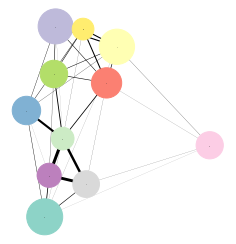

In [113]:
with rc_context({'figure.figsize': (4, 4),'axes.labelsize': False,'axes.titlesize':False}):
    sc.pl.paga(rna, threshold=0.02, show=False, frameon=False,node_size_scale=5,edge_width_scale=0.4,fontsize=0)
    plt.savefig('../results/preprocess/paga.pdf')

In [114]:
sc.tl.draw_graph(rna, init_pos='paga')
rna.uns['iroot'] = np.flatnonzero(rna.obs['leiden']  == '6')[0]
sc.tl.dpt(rna)
rna.obs['distance'] = rna.obs['dpt_pseudotime']
# create a list of our conditions
conditions = [
    (rna.obs['distance'] > 0.85) & (rna.obs['distance'] <= 0.9),
    (rna.obs['distance'] > 0.875) & (rna.obs['distance'] <= 0.925), 
    (rna.obs['distance'] > 0.90) & (rna.obs['distance'] <= 0.95),
    (rna.obs['distance'] > 0.925) & (rna.obs['distance'] <= 0.975),
    (rna.obs['distance'] > 0.95) & (rna.obs['distance'] <= 1),
]

# create a list of the values to assign each condition
values = ['t0', 't1', 't2', 't3','t4']

# create a new column and use np.select to assign values to it using lists as arguments

rna.obs['time3'] = np.select(conditions, values)

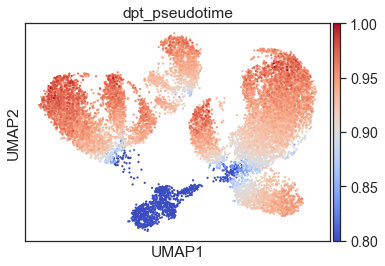

In [115]:
maxabs = max(abs(rna.obs['dpt_pseudotime']))
minabs = 0.8 #min(abs(rna_prod.obs['pseudotime']))
sc.pl.umap(rna, color='dpt_pseudotime', cmap="coolwarm", s=20, vmin=minabs, vmax=maxabs)

In [117]:
# transform UMAP coordinates to match Cheng et al. version
# rna = sc.read('../data/preprocessed_data/rna_pseudotime.h5')

# Extract the UMAP coordinates
umap_coords = rna.obsm['X_umap']

# Rotate the coordinates 180 degrees by flipping them upside down
umap_coords_rotated = umap_coords * [-1, -1]

# Replace the original UMAP coordinates with the rotated ones
rna.obsm['X_umap'] = umap_coords_rotated

In [118]:
# write rna obj with pseudotime data and rotated UMAP coordinates
rna.write('../data/preprocessed_data/rna_pseudotime.h5')

In [119]:
rna.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample,leiden,Ig,IgL,IgH,sec,dpt_pseudotime,distance,time3
AAACCCAAGTACTGTC-1-0,3128,3128,21325.0,909.0,4.262603,0,1,G,kappa,G1,x,0.884599,0.884599,t0
AAACCCAAGTGAATAC-1-0,1774,1774,6060.0,518.0,8.547854,0,3,M,kappa,M,x,0.933548,0.933548,t2
AAACCCAGTCCACAGC-1-0,2914,2914,19771.0,792.0,4.005867,0,1,G,kappa,G1,hi,0.906659,0.906659,t1
AAACCCATCACAGTGT-1-0,3122,3122,12608.0,757.0,6.004125,0,1,M,kappa,M,hi,0.783142,0.783142,0
AAACCCATCCCTCTCC-1-0,3021,3021,16684.0,247.0,1.480460,0,1,G,kappa,G1,hi,0.892763,0.892763,t0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGACTCCT-1-2,2467,2467,14874.0,309.0,2.077451,2,7,M,lambda,M,x,0.934061,0.934061,t2
TTTGTTGAGGTACAAT-1-2,2159,2159,14240.0,170.0,1.193820,2,7,M,lambda,M,x,0.947517,0.947517,t2
TTTGTTGAGTAACGAT-1-2,2665,2665,18230.0,674.0,3.697202,2,5,A,kappa,A,lo,0.915166,0.915166,t1
TTTGTTGCACGTTGGC-1-2,2211,2211,19481.0,384.0,1.971151,2,5,A,kappa,A,lo,0.968185,0.968185,t3


/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


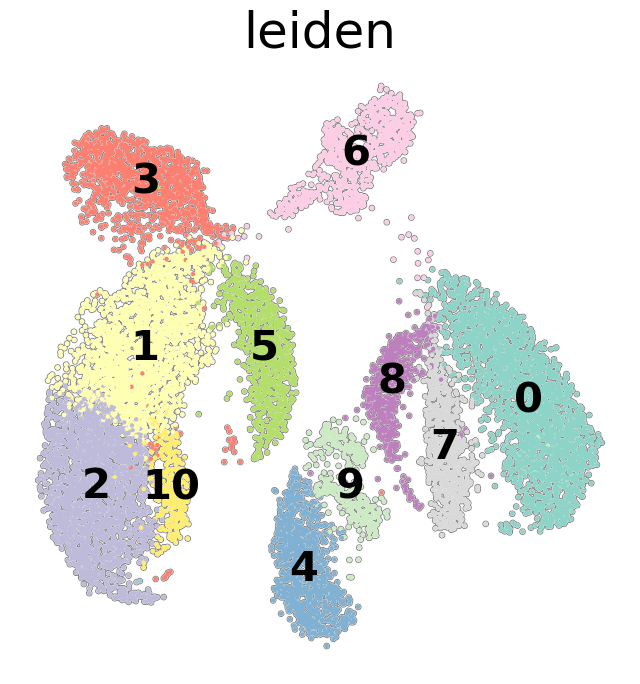

In [93]:
# leiden plot
# axis_fontsize=40

with rc_context({'figure.figsize': (8,8),'axes.labelsize' : 'large',
                'font.size': '30'}):
    
    sc.pl.umap(rna, color=["leiden"], size=40,alpha=1,
               legend_loc="on data", frameon=False,outline_width=(0.2, 0.05), outline_color=('grey', 'white'),
               add_outline=True,palette='Set3', show=False)

    plt.show()
# plt.savefig('../results/umap/leiden_outline.pdf')

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


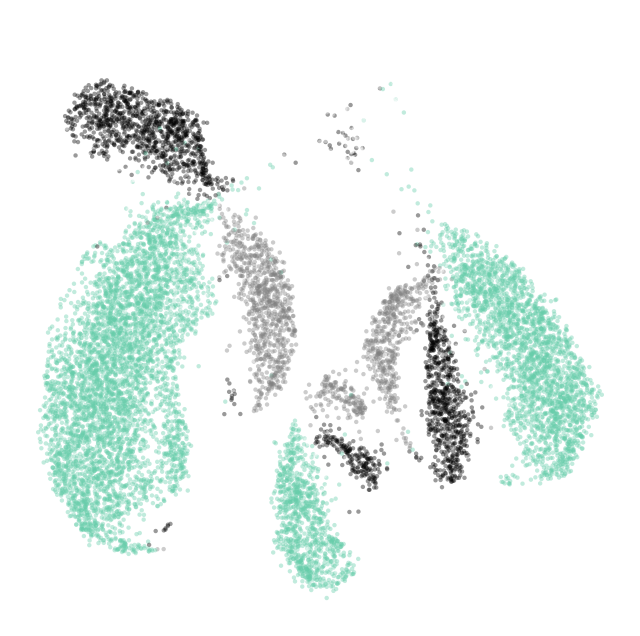

In [52]:
# IGH chains

with rc_context({'figure.figsize': (8, 8)}):    
    ax=sc.pl.umap(rna, color=["Ig"], size=40,
               palette={'A':'grey','M':'k','G':'mediumaquamarine','x':'white'},alpha=0.4,add_outline=False,
              frameon=False,legend_loc='None', show=False)
    ax.set_title('')   
    
plt.savefig('../results/umap/igh.pdf')

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


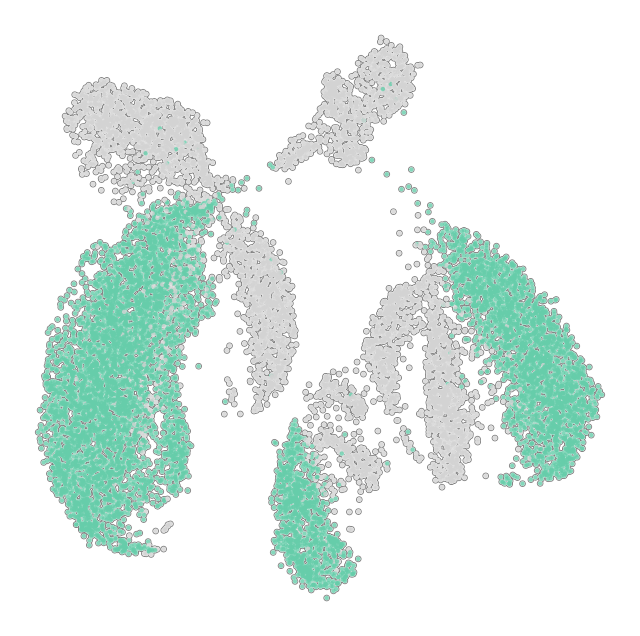

In [6]:
# IGH chains

# with rc_context({'figure.figsize': (8, 8)}):    
#     ax=sc.pl.umap(rna, color=["Ig"], size=40,
#                palette={'A':'grey','M':'k','G':'mediumaquamarine','x':'white'},alpha=0.4,add_outline=False,
#               frameon=False,legend_loc='None', show=False)
#              add_outline=False, outline_width=(0.2, 0.05), outline_color=('grey', 'white'),frameon=False, ax=ax)

with rc_context({'figure.figsize': (8, 8)}):
    ax=sc.pl.umap(rna,color=['Ig'],
      size=40,show=False, alpha=0.8, 
        palette={
        "G": "mediumaquamarine",
        "M": "lightgrey",
        'A':'lightgrey',
        'x': 'lightgrey'}, 
         add_outline=True, outline_width=(0.2, 0.05), outline_color=('grey', 'white'),frameon=False,
               legend_loc="None")
    ax.set_title('')   
    
plt.savefig('../results/umap/igh_iggonly.pdf')

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


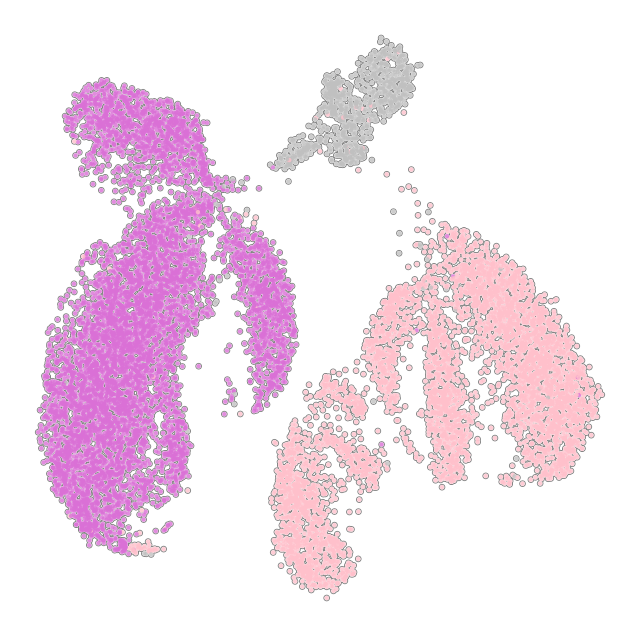

In [66]:
# IGL chains

with rc_context({'figure.figsize': (8, 8)}):
    ax=sc.pl.umap(rna,color=['IgL'],
      size=40,show=False, alpha=0.8, 
        palette={
        "kappa": "orchid",
        "lambda": "pink",
        'M':'silver'}, 
         add_outline=True, outline_width=(0.2, 0.05), outline_color=('grey', 'white'),frameon=False,
               legend_loc="None")
#     ax=sc.pl.umap(rna, color=["Ig"], size=40,
#                palette={'A':'grey','M':'k','G':'mediumaquamarine','x':'white'},alpha=0.4,add_outline=False,
#               frameon=False,legend_loc='None', show=False)
    ax.set_title('')   
    
plt.savefig('../results/umap/igl_outline.pdf')

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


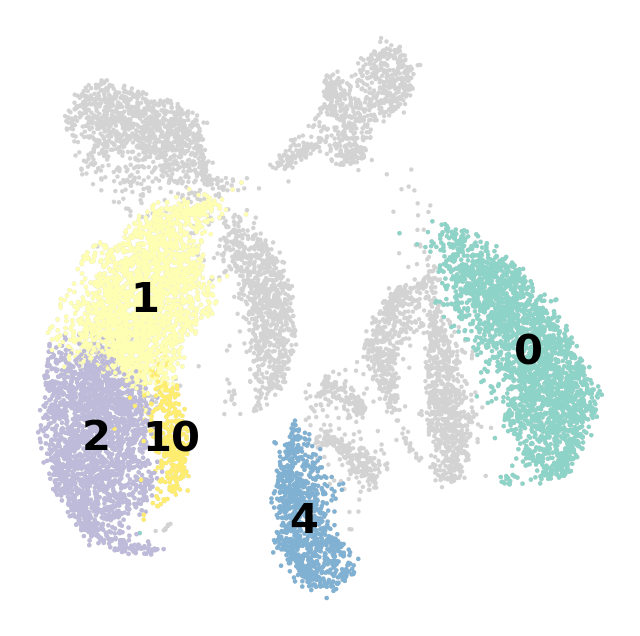

In [134]:
# IGG clusters
gcluster=rna[(rna.obs.leiden=="1")|(rna.obs.leiden=="2")|(rna.obs.leiden=="10")|(rna.obs.leiden=="0")|(rna.obs.leiden=="4")]

with rc_context({'figure.figsize': (8,8),'axes.labelsize' : 'large',
                'font.size': '30'}):
    ax = sc.pl.umap(rna, size=40, show=False)
    sc.pl.umap(gcluster,color=['leiden'],
      size=40,show=False, alpha=1, legend_loc="on data",
 
         add_outline=False, outline_width=(0.2, 0.05), outline_color=('grey', 'white'),frameon=False, ax=ax)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
# plt.savefig('../results/umap/gumap.png')

In [67]:
import seaborn as sns

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


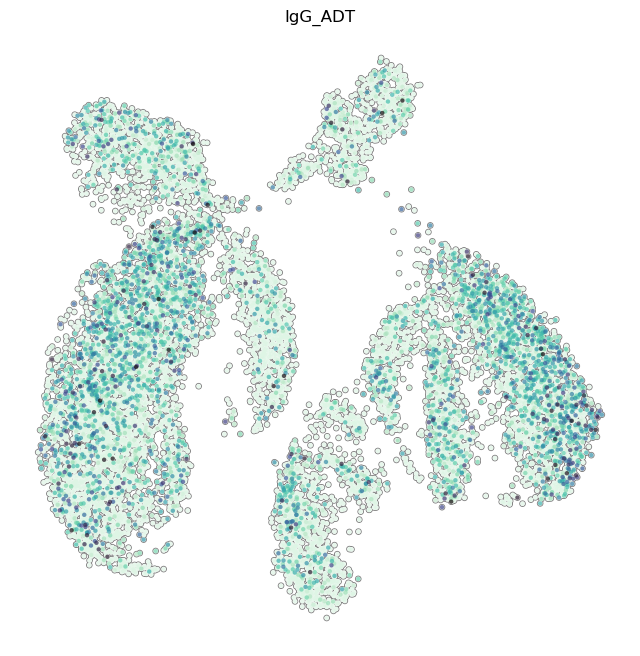

In [130]:
# s=20
with rc_context({'figure.figsize': (8, 8)}):

    ax = sc.pl.umap(rna, color=['IgG_ADT'],size=40,
                    palette='mako',color_map='mako_r',vmin=4.5, #vmax=7.5,
                    add_outline=True,
                    frameon=False,
                    show=False,outline_width=(0.2, 0.05), outline_color=('grey', 'white'),
                   colorbar_loc=None)
plt.savefig('../results/umap/iggadt.pdf')

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


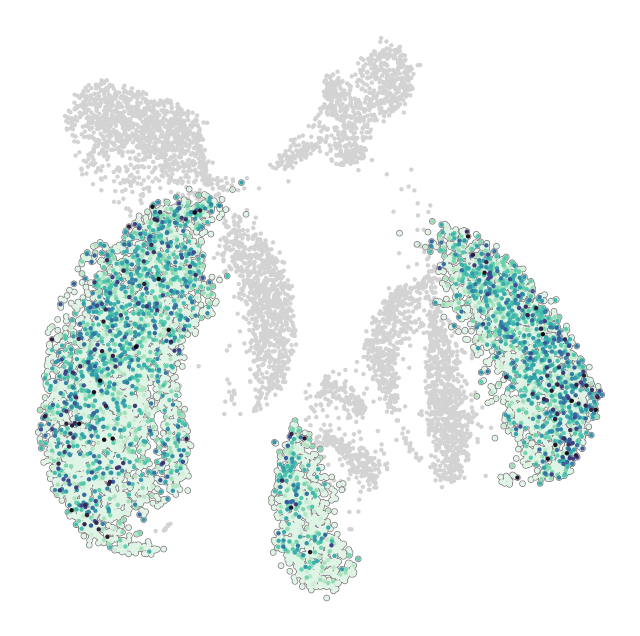

In [146]:
# gcluster=rna[(rna.obs.leiden=="1")|(rna.obs.leiden=="2")|(rna.obs.leiden=="10")|(rna.obs.leiden=="0")|(rna.obs.leiden=="4")]

with rc_context({'figure.figsize': (8,8),'axes.labelsize' : 'large',
                'font.size': '30'}):
    ax = sc.pl.umap(rna, size=40, show=False)
    sc.pl.umap(gcluster,color=['IgG_ADT'],palette='mako',color_map='mako_r',vmin=4.5,
      size=40,show=False, alpha=1, legend_loc="on data",
         add_outline=True, outline_width=(0.2, 0.05), outline_color=('grey', 'white'),frameon=False, ax=ax,
              colorbar_loc=None)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')

plt.savefig('../results/umap/G_iggadt.pdf')

/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/Users/jasminetat/opt/anaconda3/envs/secseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


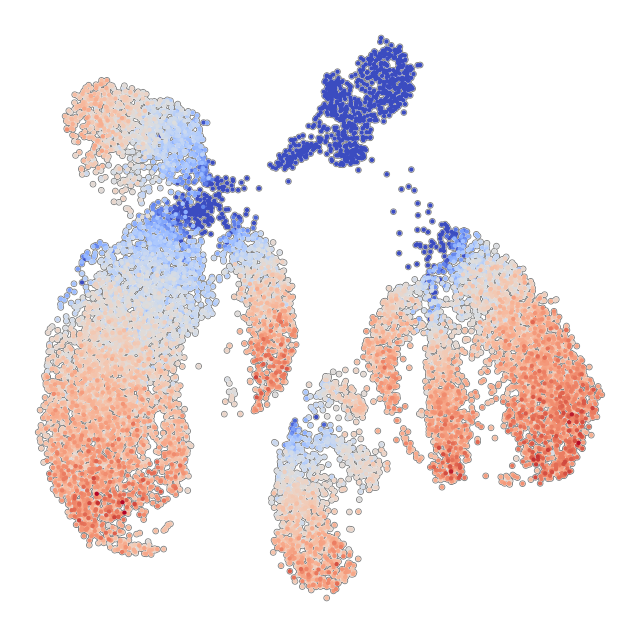

In [163]:
with rc_context({'figure.figsize': (8,8),'axes.labelsize' : 'large',
                'font.size': '30'}):
#     ax = sc.pl.umap(rna, size=40, show=False)
    ax = sc.pl.umap(rna,color='dpt_pseudotime',cmap='coolwarm',vmin=0.85,
      size=40,show=False, alpha=1, legend_loc="on data",
         add_outline=True, outline_width=(0.2, 0.05), outline_color=('grey', 'white'),frameon=False,
              colorbar_loc=None)
#     plt.show()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
plt.savefig('../results/umap/pseudotime.pdf')